# Evolution of COVID-19

In [1]:
%matplotlib nbagg
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


# Load the data

In [2]:
import pandas as pd
from datetime import datetime
from IPython.display import display, Markdown
import plotly.express as px
import plotly.graph_objects as go

## Reformat it so is pandas friendly

In [431]:
def parse_data(fname):
    with open(fname) as f:
        docs = list(csv.DictReader(f))
        
    new_docs = []
    for doc in docs:
        meta = {k: doc[k] for k in ['Province/State', 'Country/Region', 'Lat', 'Long']}
        for k, v in doc.items():
            if k in meta: continue
            new_doc = meta.copy()
            new_doc['date'] = datetime.strptime(k, '%m/%d/%y')
            new_doc['cnt'] = int(v)
            new_docs.append(new_doc)


    return (
        pd.DataFrame(new_docs)
          .rename(
              columns={
                  'Province/State': 'province',
                  'Country/Region': 'country',
                  'Lat': 'lat', 'Long': 'long'
              }
          ).groupby(['date', 'country'])
          .cnt.sum()
          .reset_index()
    )

In [432]:
df = parse_data('csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

In [433]:
recovered_df = parse_data('csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')
recovered_df = recovered_df.rename(columns=dict(cnt='recovered'))

death_df = parse_data('csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')
death_df = death_df.rename(columns=dict(cnt='death'))

In [434]:
df = df.merge(recovered_df, on=('country', 'date')).merge(death_df, on=('country', 'date'))

In [435]:
def get_rate(df, min_cnt=100, rolling_win=7):
    s = df.groupby('date').cnt.sum().sort_index().rolling(rolling_win).mean()
    s = s[s >= min_cnt]
    return s / s.shift(1) 

def plot_rate(fig, rate, name, line=None, opacity=None):
    fig.add_trace(
        go.Scatter(
            x=rate.index,
            y=rate.values,
            name=name,
            line=line,
            opacity=opacity
        )
    )

In [436]:
cnt_by_country = df.groupby('country').cnt.max().sort_values(ascending=False)
df_wtotal = (
    df.merge(cnt_by_country.reset_index().rename(columns=dict(cnt='total')), on='country')
      .sort_values('total', ascending=False)
)


In [437]:
dfs = []
for c in df_wtotal.country.unique():
    cdf = df_wtotal[df_wtotal.country == c].set_index('date').sort_index()
    cdf['rate'] = np.minimum(1.6, cdf.cnt / cdf.cnt.shift(1)).rolling(3).mean().fillna(1.6)
    cdf['cum'] = cdf.cnt.cumsum()
    dfs.append(cdf)
    
df_wtotal = pd.concat(dfs).reset_index()

In [438]:
df_wtotal['date'] = df_wtotal['date'].apply(lambda x: x.strftime('%Y-%m-%d'))
df_wtotal = df_wtotal.dropna()

In [439]:
df_wtotal['cnt'] = np.maximum(1, df_wtotal['cnt'])
df_wtotal['log(cases)'] = np.log10(df_wtotal.cum + 1)
df_wtotal['log(death)'] = np.log10(df_wtotal.death + 1)

# Start plotting

In [440]:
today = df_wtotal.date.max()
today_df = df_wtotal[df_wtotal.date == today].copy()

In [362]:
today_df.cnt.sum()

181547

In [363]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [364]:
import seaborn as sns
sns.set()

<IPython.core.display.Javascript object>


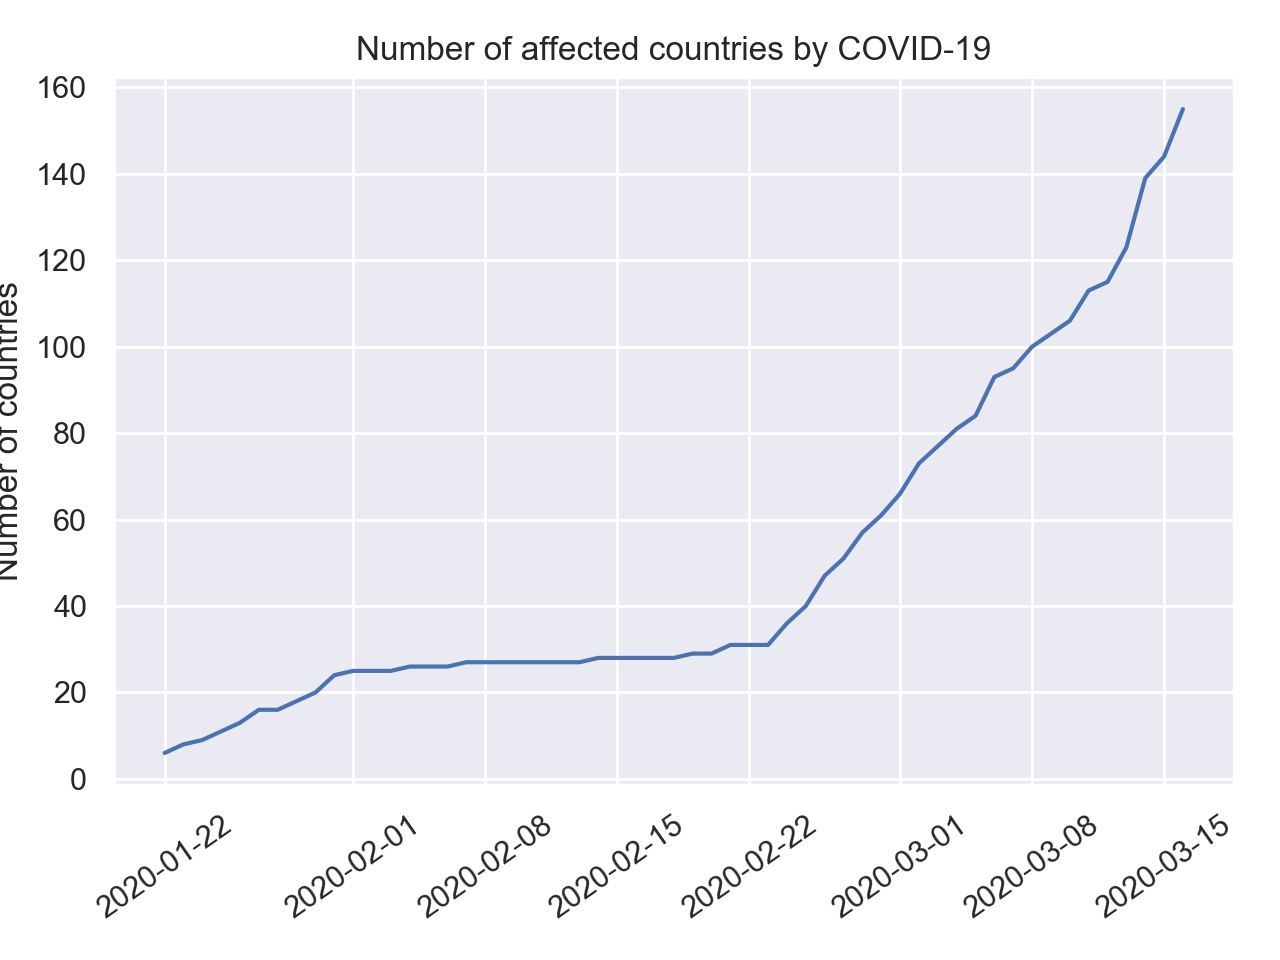

Text(35.625, 0.5, 'Number of countries')

In [365]:
from collections import defaultdict

d = defaultdict(set)
for doc in df[df.cnt>0].to_dict(orient='records'):
    d[doc['date']].add(doc['country'])

acum = set()
for date, countries in sorted(d.items()):
    acum.update(countries)
    d[date] = acum.copy()

d = {k: len(v) for k, v in d.items()}
figure()
title('Number of affected countries by COVID-19')
plot(*zip(*sorted(d.items())))
xticks(rotation=35)
tight_layout()
ylabel('Number of countries')

## Current status

<IPython.core.display.Javascript object>


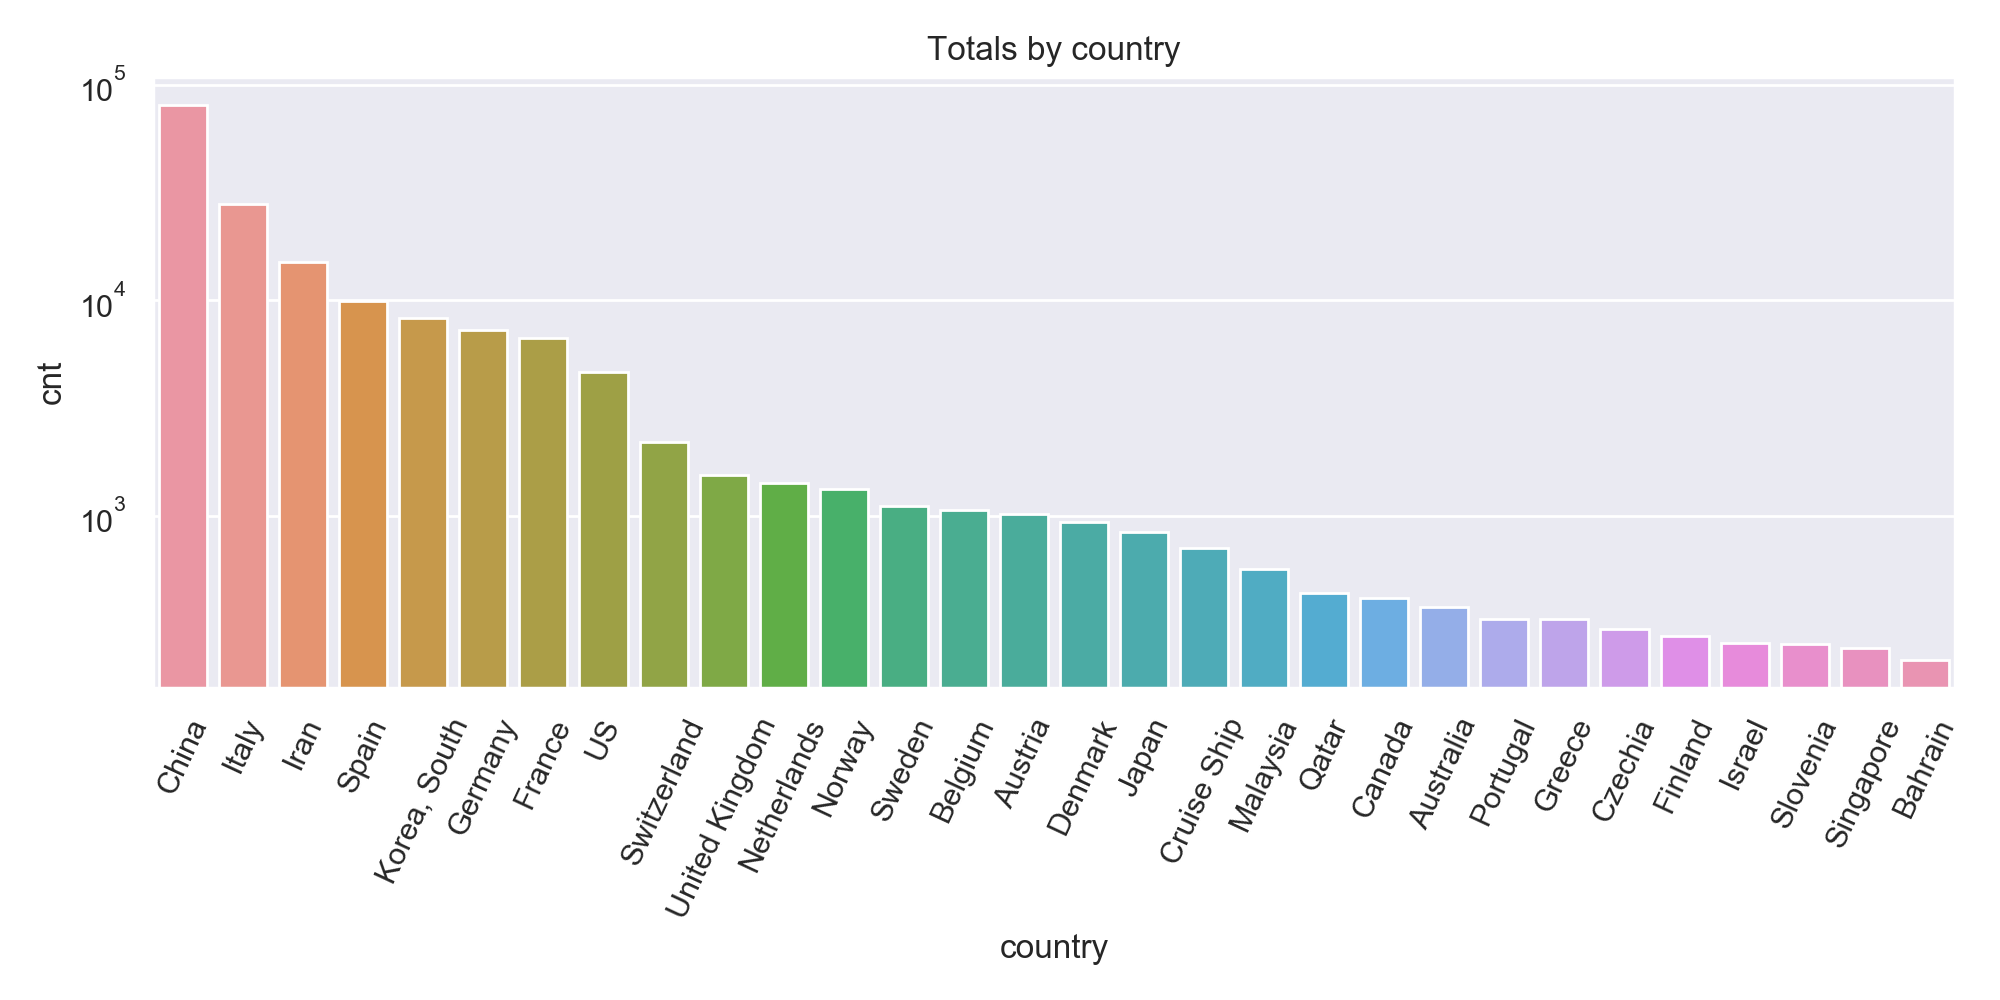

In [327]:
figure(figsize=(10,5))
sns.barplot(
    data=df_wtotal[df_wtotal.country.isin(cnt_by_country[:30].index)], 
    x='country', 
    y='cnt', 
    estimator=np.max,
    ci=None
)
plt.xticks(rotation=65)
gca().set_yscale('log')
title('Totals by country')
plt.tight_layout()

In [334]:
today_df['size'] = today_df['log(cases)'] * 3
fig = px.scatter(today_df, x='cnt', y='rate', color='country', text='country', log_x=True, size='size')
fig.update_layout(showlegend=False)


## Total number of reported cases per country

In [133]:
df_wtotal['ds'] = df_wtotal.date.apply(lambda x: x.strftime('%Y-%m-%d'))
df_wtotal = df_wtotal.sort_values(['total', 'ds'], ascending=[False, True])

In [134]:
px.bar(
    df_wtotal[df_wtotal.country.isin(cnt_by_country[:50].index)], 
    x='country', y='cnt', animation_frame='ds', log_y=True
)

## Evolution on <growth rate, confirmed cases> space

In [441]:
df_wtotal['size'] = 25

In [444]:
from tqdm.auto import tqdm
import plotly.graph_objects as go

cumulative_frames = []
dates = sorted(df_wtotal.date.unique())

days_by_country = df_wtotal[df_wtotal.cnt>1].groupby('country').date.count().to_dict()

for i, date in enumerate(tqdm(dates[-4:])):
    past_df = df_wtotal[(df_wtotal.date <= date) & (df_wtotal.cnt > 0)]
    curr_df = past_df[(past_df.date == date)]
    data = []
    md = past_df['log(cases)'].min()
    Md = past_df['log(cases)'].max()
    
    for c in past_df.country.unique():
        c_past_df = past_df[past_df.country == c]
        c_curr_df = curr_df[curr_df.country == c]
#         if c_curr_df.cnt.max() < 100 and date > dates[0]: continue
            
        color = cm((c_curr_df['log(cases)'].iloc[0] - md) / (Md - md))
        color = f'rgba({int(color[0] * 255)}, {int(color[1] * 255)}, {int(color[2] * 255)}, 0.7)'
        
        opacity = c_curr_df['log(cases)'].iloc[0] / past_df['log(cases)'].max()
        
        if days_by_country.get(c, 0) > 30:
            mask = c_past_df.rate < 1.6
            if mask.sum() > 0:
                data.append(
                    go.Scatter(
                        x=c_past_df[mask].cnt, 
                        y=c_past_df[mask].rate, 
                        name=c, uid=f'line_{c}', legendgroup=c,
                        mode='lines', showlegend=False,
                        opacity=0.75 * opacity, 
                        line=dict(
                            width=2, color=color, dash='dash'
                        )
                    )
                )
            
        data.append(
            go.Scatter(
                x=c_curr_df.cnt, 
                y=c_curr_df.rate, 
                mode='text+markers', 
                text=c_curr_df.country, uid=f'scat_{c}', legendgroup=c,
                name=c,
                textfont=dict(size=((1.5 + c_past_df['log(cases)']) * 4).astype(int)),
#                 opacity=min(1, 1.5 * opacity),
                marker=dict(
                    size=24 + c_past_df['log(cases)'] * 12, 
                    color=color
                )
            )
        )
    
    cumulative_frames.append(go.Frame(data=data))

#     break

In [445]:
layout = go.Layout(
    height=800,
    xaxis=dict(type='log', range=[0, 5.5]),
    yaxis=dict(range=[0.9, 1.8], autorange=False),
    title="Start Title",
    updatemenus=[dict(
        type="buttons",
        buttons=[dict(label="Play",
                      method="animate",
                      args=[None])])]
)

fig = go.Figure(
    data=cumulative_frames[0].data,

    layout=layout,
    frames=cumulative_frames
)

# fig.update_layout(showlegend=False)

fig.show()

In [456]:
fig = px.scatter(
    df_wtotal, x="cnt", y="rate", animation_frame="date",
    log_x=True, text='country', color='log(cases)', size='size',
    range_x=[.1, df_wtotal.cum.max()], range_y=[df_wtotal.rate.min(), df_wtotal.rate.max()]
)

fig.update_traces(textfont_size=8)

fig.show()

In [89]:
import operator
from pprint import pprint 
from itertools import groupby
from functools import partial

min_rate = 1.2
min_cnt = 1000

today = df_wtotal.date.max()
today_df = df_wtotal[df_wtotal.date == today].copy()

def op(x, t): return '<' if x < t else '>'

today_df['cuadrant'] = (
    f'cnt : ' + today_df.cnt.apply(lambda x: op(x, min_cnt) + f' {min_cnt}') + ', ' +
    f'rate ' + today_df.rate.apply(lambda x: op(x, min_rate) + f' {min_rate}') 
)
country_cuadrant = today_df.set_index('country').cuadrant.to_dict()
df_wtotal['cuadrant'] = df_wtotal.country.apply(country_cuadrant.get)

In [90]:
fig = px.line(
    df_wtotal,
    x='date', y='cnt', line_group='country', color='cuadrant', log_y=True, 
)
fig.show()

cols = 5
template = '{:<20}'
key = lambda x: x[1]
for cuad, countries in groupby(sorted(country_cuadrant.items(), key=key), key=key):
    display(Markdown(f'# {cuad}'))
    countries = [c for c, _ in countries]
    for start in range(0, len(countries), cols):
        end = start + cols
        cs = countries[start: end]
        print('\t' + (template * len(cs)).format(*cs))


# cnt : < 1000, rate < 1.2

	Denmark             Japan               Cruise Ship         Qatar               Singapore           
	Bahrain             Iceland             Iraq                Thailand            India               
	Kuwait              Egypt               San Marino          United Arab EmiratesTaiwan*             
	Vietnam             Georgia             Costa Rica          Oman                Maldives            
	New Zealand         Paraguay            Cuba                Burkina Faso        Honduras            
	Monaco              Cameroon            Nigeria             Cote d'Ivoire       Andorra             
	Togo                Bhutan              Mongolia            Holy See            Nepal               


# cnt : < 1000, rate > 1.2

	Belgium             Austria             Malaysia            Greece              Australia           
	Czechia             Canada              Israel              Portugal            Finland             
	Slovenia            Estonia             Brazil              Philippines         Romania             
	Ireland             Poland              Indonesia           Lebanon             Saudi Arabia        
	Chile               Russia              Luxembourg          Slovakia            Pakistan            
	Bulgaria            South Africa        Brunei              Croatia             Algeria             
	Serbia              Argentina           Peru                Panama              Albania             
	Mexico              Colombia            Hungary             Latvia              Morocco             
	Ecuador             Belarus             Armenia             Cyprus              Senegal             
	Bosnia and HerzegovinaMoldova             Azerbaijan          Malta              

# cnt : > 1000, rate < 1.2

	China               Iran                Korea, South        


# cnt : > 1000, rate > 1.2

	Italy               Spain               Germany             France              US                  
	Switzerland         Norway              United Kingdom      Netherlands         Sweden              


In [332]:
def get_current_rate(df, window=7):
    dates = sorted(df.date.unique())
    current_df = df[df.date >= dates[-window]]
    res = {
        c: get_rate(current_df[current_df.country==c], rolling_win=5, min_cnt=10).mean() 
        for c in current_df.country.unique()
    }
    return {k: v for k, v in res.items() if not np.isnan(v)}

In [333]:
fig = go.Figure()

to_plot = df.groupby('country').cnt.sum().sort_values(ascending=False)[:50]
to_plot_rate = get_current_rate(df)
m = min(to_plot_rate.values())
M = max(to_plot_rate.values())

for country, cnt in to_plot.items():
    c_df = (
        df[df.country == country]
          .groupby('date')
          .cnt.sum()
          .reset_index()
          .sort_values('date')
    )
    c_df = c_df[c_df.cnt > 0]

    lum = int((to_plot_rate[country] - m) / (M - m) * 100)
    
    fig.add_trace(
        go.Scatter(
            x=c_df.date,
            y=c_df.cnt,
            name=country,
            line=dict(color=f'hsla(10, {lum}%, 50%, 0.5)'),
            opacity=0.8
        )
    )

fig.update_layout(yaxis_type="log")

display(Markdown("""
## Confirmed cases evolution by country
The lines that are most red correspond to countries that have the most rate of growth of COVID-19
"""
))
fig.show()


## Confirmed cases evolution by country
The lines that are most red correspond to countries that have the most rate of growth of COVID-19


## Rates of most affected countries

In [13]:
fig = go.Figure()

T = 1500

for country in df.country.unique():
    if cnt_by_country[country] < T: continue
    rate = get_rate(df[df.country == country])
    line = dict(width=8) if country == 'Mainland China' else None
    plot_rate(fig, rate, country, opacity=0.8, line=line)

rate = get_rate(df[df.country.isin([c for c, cnt in cnt_by_country.items() if cnt < T])])
plot_rate(fig, rate, f'Countries with less than {T}', dict(width=8))

rate = get_rate(df[df.country.isin([c for c, cnt in cnt_by_country.items() if cnt >= T and c != 'Mainland China'])])
plot_rate(fig, rate, f'Countries with more than {T}', dict(width=8))

fig.show()